# 本程序的目标：探究GNN在流形学习与生成类似的流形的表现

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import torch
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [2]:
def createData1():
    """
    2D线性
    """
    x1 = np.linspace(0.1, 0.9, 100)
    x2 = x1.copy()
    x3 = x1.copy()
    X = np.vstack([x1, x2]).T  # 2D

    data = X[:100, :]
    data = np.delete(data, range(25, 75), axis=0)
    return data

def createData2():
    """
    3D线性
    """
    x1 = np.linspace(0.1, 0.9, 100)
    x2 = x1.copy()
    x3 = x1.copy()
    X = np.vstack([x1, x2, x3]).T  # 3D

    data = X[:100, :]
    data = np.delete(data, range(25, 75), axis=0)
    return data

def createData3():
    """
    2D 非线性：抛物线
    """

    x1 = np.linspace(0.1, 0.9, 100)
    x2 = (x1 - 0.5)**2
    X = np.vstack([x1, x2]).T  # 2D
    data = X[:100, :]
    data = np.delete(data, range(25, 75), axis=0)
    return data

def createData4():
    """
    2D 非线性：抛物线（单边）
    """

    x1 = np.linspace(0.1, 0.9, 100)
    x2 = x1**2
    X = np.vstack([x1, x2]).T  # 2D
    data = X[:100, :]
    return data

def createData5(n = 100):
    """
    2D 非线性：圆
    """

    dr,angle = np.random.randn(n)*0.05, 1.0*np.pi*np.random.rand(n)
    r = dr+1.0
    x = r*np.sin(angle)
    y = r*np.cos(angle)
    data = np.concatenate([x[np.newaxis,:], y[np.newaxis,:]]).T
    data = np.delete(data, range(25, 75), axis=0)
    return data

def createData6():
    """
    2D 非线性：|x-0.5|
    """

    x1 = np.linspace(0.1, 0.9, 100)
    x2 = np.abs(x1 - 0.5)
    X = np.vstack([x1, x2]).T  # 2D
    data = X[:100, :]
    return data

def normalization(data):
    """
    把data归一化到0到1
    """

    # data = (data - np.mean(data, 0)) / (np.max(data, 0) - np.min(data, 0))
    # data = data / np.max(data, 0)
    return data

In [93]:
def data_cluster(data):
    """
    数据聚类。
    方法：先用DBScan，如果发现聚类数目过多，则采用k-means
    """

    distance_matrix = distance.cdist(data, data, 'euclidean')

    y_pred = DBSCAN(eps = np.mean(distance_matrix)).fit_predict(data)
    cluster_num = len(np.unique(y_pred))
    if cluster_num > data.shape[0] // 4:
        y_pred = KMeans(n_clusters=2).fit_predict(data)
    
    # y_pred = KMeans(n_clusters=2).fit_predict(data)

    unique_cluster_num = np.unique(y_pred)

    data_set = []
    for i in range(len(unique_cluster_num)):
        data_set.append(data[np.where(y_pred == unique_cluster_num[i])[0], :])
    
    return data_set

In [14]:
## 数据排序
def sort_data(data):
    N = data.shape[0]
    # 计算距离
    distance_matrix = distance.cdist(data, data, 'euclidean')
    distance_matrix[np.where(distance_matrix < 1e-12)] = np.inf
    # print(distance_matrix)
    # 找出距离最近的两个点
    min_index = np.argmin(distance_matrix)
    min_index = [min_index//N, min_index%N]
    # 开始排序
    remain = list(range(N))
    order = [min_index[0], min_index[1]]
    remain.remove(order[0])
    remain.remove(order[-1])
    while(len(remain) != 0):
        # print(distance_matrix)
        # 找到与当前order0头或尾最近的点
        min_index_A = np.argmin(distance_matrix[order[0], remain])
        min_index_B = np.argmin(distance_matrix[order[-1], remain])
        if distance_matrix[order[0], remain[min_index_A]] <= distance_matrix[order[-1], remain[min_index_B]]:
            order = [remain[min_index_A]] + order
            remain.remove(remain[min_index_A])
        else:
            order = order + [remain[min_index_B]]
            remain.remove(remain[min_index_B])
    # print(order)
    return data[order, :]

In [115]:
## 子网络
class SubNet(nn.Module):
    def __init__(self, hidden_dim=1000, epochs=1000):
        """
        子网络：拟合隐变量与某一维数据的关系
        """
        super(SubNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1, bias=True),
        )
        self.loss_list = []  # 用于记录训练过程的loss value
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.epochs = epochs

    def forward(self, x):
        x = self.model(x)
        return x


In [116]:
def train(data_set, epochs=1000):
    """
    注意：传入的data_set是聚类后的数据,已经归一化,无需再归一化.这里只需对data_set的每一类数据再进行排序即可
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"

    # 存储所有的网络输出数据
    total_predicts_data = []

    # 创建网络
    network_list = []

    print(len(data_set))
    
    for k in range(len(data_set)):
        data = data_set[k]

        # 数据排序
        data = sort_data(data)
        
        data = torch.as_tensor(data, dtype=torch.float32).to(device)
        Dim = data.shape[1]
        data_num = data.shape[0]
        T = torch.linspace(-0.5, 0.5, data_num, dtype=torch.float32).reshape(-1, 1).to(device)  # 创建隐变量
        model_list = []
        for i in range(Dim):
            model_list.append(SubNet(epochs=epochs).to(device))
        
        predicts_data = []  # 用于记录predicts

        # 训练网络
        for i in range(Dim):
            print('model: ', i)
            model = model_list[i]
            sub_data = data[:, [i]]
            for epoch in range(1, model.epochs+1):
                # print(epoch)
                predicts = model(T)
                loss = model.loss_function(predicts, sub_data)
                model.loss_list.append(loss.cpu().detach().numpy())
                model.optimizer.zero_grad()
                loss.backward()
                model.optimizer.step()
            predicts_data.append(predicts.cpu().detach().numpy())
            
        predicts_data = np.hstack(predicts_data)
        total_predicts_data.append(predicts_data)

        # 绘制训练过程图
        fig = plt.figure()
        for i in range(Dim):
            t = list(range(len(model_list[i].loss_list)))
            plt.plot(t, model_list[i].loss_list, label=f'model_{str(i)}')
            plt.legend()
            plt.xlabel('Epoch Number')
            plt.ylabel('Loss Value')
        plt.show()
        network_list.append(model_list)
    
    total_predicts_data = np.vstack(total_predicts_data)

    return network_list, total_predicts_data

2
model:  0
model:  1


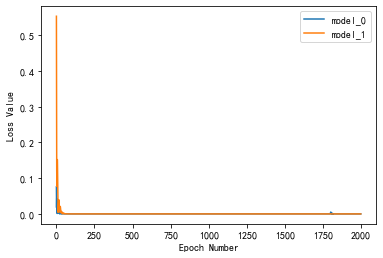

model:  0
model:  1


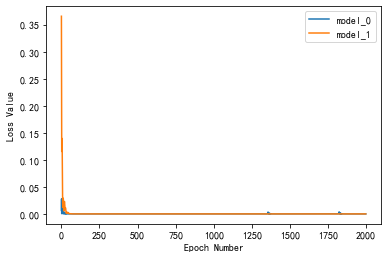

In [85]:
## Device Setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# 准备数据
data = createData3()
data = np.unique(data, axis=0)
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

# 数据聚类，得到的data_set是一个list，每个元素都是N_k行D列的data数据。k为该类的样本数
data_set = data_cluster(data)

# 网络训练
network_list, total_predicts_data = train(data_set)

In [86]:
# 网络使用
total_predicts_data = []
for k in range(len(data_set)):
    model_list = network_list[k]
    data_num = data_set[k].shape[0]
    # T = torch.as_tensor(np.random.rand(200).reshape(-1, 1), dtype=torch.float32).to(device)
    T = torch.linspace(-1, 1, data_num, dtype=torch.float32).reshape(-1, 1).to(device)  # 创建隐变量
    predicts_data = []
    for i in range(len(model_list)):
        model = model_list[i]
        predicts = model(T)
        predicts_data.append(predicts)
    predicts_data = torch.hstack(predicts_data).cpu().detach().numpy()
    total_predicts_data.append(predicts_data)
total_predicts_data = np.vstack(total_predicts_data)

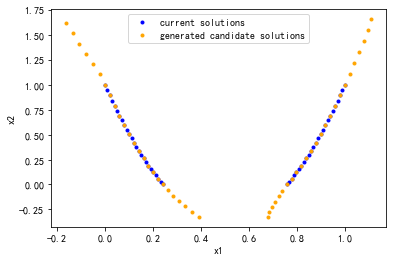

In [87]:
# predicts_data = old_predicts_data.copy()
# 绘图
fig = plt.figure()
if data.shape[1] == 2:
    plt.plot(data[:, 0], data[:, 1], 'o', markersize=3, color='blue', label='current solutions', )  # 绘制真实数据的图
    plt.plot(total_predicts_data[:, 0], total_predicts_data[:, 1], 'o', markersize=3, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
    plt.xlabel('x1')
    plt.ylabel('x2')
elif data.shape[1] == 3:
    ax = fig.gca(projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2], 'o', markersize=3, color='blue', label='current solutions', )  # 绘制真实数据的图
    ax.plot(total_predicts_data[:, 0], total_predicts_data[:, 1], total_predicts_data[:, 2], 'o', markersize=3, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
plt.legend()
plt.show()

# 进化算法测试部分

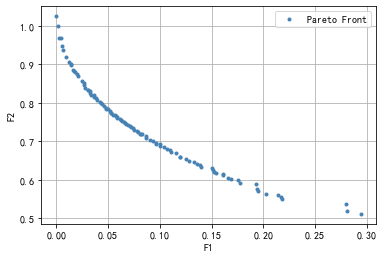

种群信息导出完毕。
用时：0.368335 秒
评价次数：20000 次
非支配个体数：100 个


In [124]:
# -*- coding: utf-8 -*-
import numpy as np
import geatpy as ea
class UF1(ea.Problem):  # 继承Problem父类
    def __init__(self):
        name = 'UF1'  # 初始化name（函数名称，可以随意设置）
        M = 2  # 初始化M（目标维数）
        maxormins = [1] * M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 30  # 初始化Dim（决策变量维数）
        varTypes = [0] * Dim  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] + [-1] * (Dim - 1)  # 决策变量下界
        ub = [1] * Dim  # 决策变量上界
        lbin = [1] * Dim  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        x1 = Vars[:, [0]]
        J1 = np.arange(2, self.Dim, 2)
        J2 = np.arange(1, self.Dim, 2)
        tmp = 6 * np.pi * x1
        f1 = x1 + 2 * np.mean((Vars[:, J1] - np.sin(tmp + np.pi / self.Dim * (J1 + 1))) ** 2, 1,
                              keepdims=True)
        f2 = 1 - np.sqrt(np.abs(x1)) + 2 * np.mean((Vars[:, J2] - np.sin(tmp + np.pi / self.Dim * (J2 + 1))) ** 2, 1, keepdims=True)
        pop.ObjV = np.hstack([f1, f2])  # 把求得的目标函数值赋值给种群pop的ObjV

    def calReferObjV(self):  # 设定目标数参考值（本问题目标函数参考值设定为理论最优值，即“真实帕累托前沿点”）
        N = 10000  # 生成10000个参考点
        ObjV1 = np.linspace(0, 1, N)
        ObjV2 = 1 - np.sqrt(ObjV1)
        referenceObjV = np.array([ObjV1, ObjV2]).T
        return referenceObjV


class WFG1(ea.Problem):  # 继承Problem父类
    def __init__(self, M=3):
        name = 'WFG1'  # 初始化name（函数名称，可以随意设置）
        maxormins = [1] * M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M + 9  # 初始化Dim（决策变量维数）
        varTypes = [0] * Dim  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Dim  # 决策变量下界
        ub = list(range(2, 2 * Dim + 1, 2))  # 决策变量上界
        lbin = [1] * Dim  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 目标函数中用到的一些参数设置
        self.K = self.M - 1
        self.L = self.Dim - self.K
        self.S = np.array([list(range(2, 2 * self.M + 1, 2))])
        self.D = 1
        self.A = np.ones((1, self.M - 1))

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        N, Lind = Vars.shape
        M = self.M
        K = self.K
        L = self.L
        S = self.S
        D = self.D
        A = np.tile(self.A, (N, 1))
        Z = Vars / np.array([range(2, 2 * Lind + 1, 2)])
        t1 = np.zeros((N, K + L))
        t1[:, :K] = Z[:, :K]
        t1[:, K:] = s_linear(Z[:, K:], 0.35)
        t2 = np.zeros((N, K + L))
        t2[:, :K] = t1[:, :K]
        t2[:, K:] = b_flat(t1[:, K:], 0.8, 0.75, 0.85)
        t3 = b_poly(t2, 0.02)
        t4 = np.zeros((N, M))
        K_divide_M_sub_1 = int(K / (M - 1))
        for i in range(1, M):
            t4[:, i - 1] = r_sum(t3[:, list(range((i - 1) * K_divide_M_sub_1, i * K_divide_M_sub_1))],
                                 list(range(2 * (i - 1) * K_divide_M_sub_1 + 1, 2 * i * K_divide_M_sub_1 + 1, 2)))
        t4[:, M - 1] = r_sum(t3[:, K: K + L], list(range(2 * (K + 1), 2 * (K + L) + 1, 2)))
        x = np.zeros((N, M))
        for i in range(1, M):
            x[:, [i - 1]] = np.max([t4[:, [M - 1]], A[:, [i - 1]]], 0) * (t4[:, [i - 1]] - 0.5) + 0.5
        x[:, [M - 1]] = t4[:, [M - 1]]
        h = convex(x)
        h[:, [M - 1]] = mixed(x)
        f = D * x[:, [M - 1]] + S * h
        pop.ObjV = f  # 把求得的目标函数值赋值给种群pop的ObjV

    def calReferObjV(self):  # 设定目标数参考值（本问题目标函数参考值设定为理论最优值，即“真实帕累托前沿点”）
        N = 10000  # 设置所要生成的全局最优解的个数
        Point, num = ea.crtup(self.M, N)  # 生成N个在各目标的单位维度上均匀分布的参考点
        M = self.M
        c = np.ones((num, M))
        for i in range(num):
            for j in range(1, M):
                temp = Point[i, j] / Point[i, 0] * np.prod(1 - c[i, M - j: M - 1])
                c[i, M - j - 1] = (temp ** 2 - temp + np.sqrt(2 * temp)) / (temp ** 2 + 1)
        x = np.arccos(c) * 2 / np.pi
        temp = (1 - np.sin(np.pi / 2 * x[:, [1]])) * Point[:, [M - 1]] / Point[:, [M - 2]]
        a = np.linspace(0, 1, 10000 + 1)
        for i in range(num):
            E = np.abs(temp[i] * (1 - np.cos(np.pi / 2 * a)) - 1 + a + np.cos(10 * np.pi * a + np.pi / 2) / 10 / np.pi)
            rank = np.argsort(E, kind='mergesort')
            x[i, 0] = a[np.min(rank[0: 10])]
        Point = convex(x)
        Point[:, [M - 1]] = mixed(x)
        referenceObjV = np.array([list(range(2, 2 * self.M + 1, 2))]) * Point
        return referenceObjV


def convex(x):
    return np.fliplr(
        np.cumprod(np.hstack([np.ones((x.shape[0], 1)), 1 - np.cos(x[:, :-1] * np.pi / 2)]), 1)) * np.hstack(
        [np.ones((x.shape[0], 1)), 1 - np.sin(x[:, list(range(x.shape[1] - 1 - 1, -1, -1))] * np.pi / 2)])


def mixed(x):
    return 1 - x[:, [0]] - np.cos(10 * np.pi * x[:, [0]] + np.pi / 2) / 10 / np.pi


def s_linear(x, A):
    return np.abs(x - A) / np.abs(np.floor(A - x) + A)


def b_flat(x, A, B, C):
    Output = A + np.min([0 * np.floor(x - B), np.floor(x - B)], 0) * A * (B - x) / B - np.min(
        [0 * np.floor(C - x), np.floor(C - x)], 0) * (1 - A) * (x - C) / (1 - C)
    return np.round(Output, 6)


def b_poly(x, a):
    return np.sign(x) * np.abs(x) ** a


def r_sum(x, w):
    Output = np.sum(x * w, 1) / np.sum(w)
    return Output


class DTLZ1(ea.Problem):  # 继承Problem父类
    def __init__(self, M=3):
        name = 'DTLZ1'  # 初始化name（函数名称，可以随意设置）
        maxormins = [1] * M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M + 4  # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim)  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Dim  # 决策变量下界
        ub = [1] * Dim  # 决策变量上界
        lbin = [1] * Dim  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        XM = Vars[:, (self.M - 1):]
        g = 100 * (self.Dim - self.M + 1 + np.sum(((XM - 0.5) ** 2 - np.cos(20 * np.pi * (XM - 0.5))), 1,
                                                  keepdims=True))
        ones_metrix = np.ones((Vars.shape[0], 1))
        f = 0.5 * np.hstack([np.fliplr(np.cumprod(Vars[:, :self.M - 1], 1)), ones_metrix]) * np.hstack(
            [ones_metrix, 1 - Vars[:, range(self.M - 2, -1, -1)]]) * (1 + g)
        pop.ObjV = f  # 把求得的目标函数值赋值给种群pop的ObjV
    
    def calReferObjV(self):  # 设定目标数参考值（本问题目标函数参考值设定为理论最优值，即“真实帕累托前沿点”）
        uniformPoint, ans = ea.crtup(self.M, 10000)  # 生成10000个在各目标的单位维度上均匀分布的参考点
        referenceObjV = uniformPoint / 2
        return referenceObjV


class IMF1(ea.Problem):  # 继承Problem父类
    def __init__(self, Dim=30):
        name = 'IMF1'  # 初始化name（函数名称，可以随意设置）
        M = 2  # 初始化M（目标维数）
        maxormins = [1] * M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        varTypes = [0] * Dim  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Dim  # 决策变量下界
        ub = [1] * Dim  # 决策变量上界
        lbin = [1] * Dim  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        t = (1 + 5 * np.tile(np.arange(2, self.Dim+1), (pop.sizes, 1))/self.Dim) * pop.Phen[:, 1:] - \
            np.tile(pop.Phen[:, 0: 1], (1, self.Dim-1))
        g = 1 + 9 * np.mean(t**2, axis=1, keepdims=True)
        pop.ObjV = np.c_[pop.Phen[:, 0:1],
                        g * (1 - np.sqrt(pop.Phen[:, 0:1] / g))]
    
    def calReferObjV(self):
        N = 10000  # 生成10000个参考点
        f1 = np.linspace(0, 1, N*self.M)
        f2 = 1 - np.sqrt(f1)
        referenceObjV = np.c_[f1, f2]
        return referenceObjV


problem = IMF1()  # 生成问题对象
"""==================================种群设置=============================="""
Encoding = 'RI'  # 编码方式
NIND = 100  # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)  # 创建区域描述器
population = ea.Population(Encoding, Field, NIND)  # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
"""================================算法参数设置============================="""
# myAlgorithm = ea.moea_MOEAD_DE_templet(problem, population)  # 实例化一个算法模板对象
myAlgorithm = ea.moea_NSGA3_templet(problem, population)  # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 200  # 最大进化代数
myAlgorithm.logTras = 0  # 设置每多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
"""==========================调用算法模板进行种群进化=========================
调用run执行算法模板，得到帕累托最优解集NDSet以及最后一代种群。NDSet是一个种群类Population的对象。
NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
详见Population.py中关于种群类的定义。
"""
[NDSet, population] = myAlgorithm.run()  # 执行算法模板，得到非支配种群以及最后一代种群
NDSet.save()  # 把非支配种群的信息保存到文件中
"""==================================输出结果=============================="""
print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
print('非支配个体数：%d 个' % NDSet.sizes) if NDSet.sizes != 0 else print('没有找到可行解！')
if myAlgorithm.log is not None and NDSet.sizes != 0:
    print('GD', myAlgorithm.log['gd'][-1])
    print('IGD', myAlgorithm.log['igd'][-1])
    print('HV', myAlgorithm.log['hv'][-1])
    print('Spacing', myAlgorithm.log['spacing'][-1])

1
model:  0
model:  1
model:  2
model:  3
model:  4
model:  5
model:  6
model:  7
model:  8
model:  9
model:  10
model:  11
model:  12
model:  13
model:  14
model:  15
model:  16
model:  17
model:  18
model:  19
model:  20
model:  21
model:  22
model:  23
model:  24
model:  25
model:  26
model:  27
model:  28
model:  29


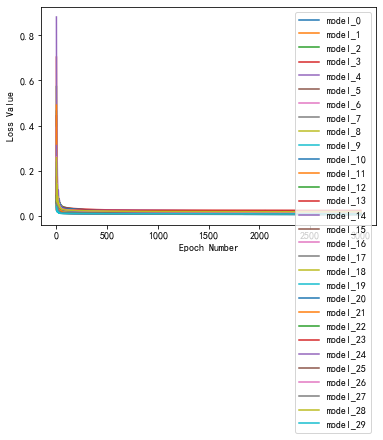

In [125]:
data = NDSet.Phen.copy()
data = np.unique(data, axis=0)
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

# 数据聚类，得到的data_set是一个list，每个元素都是N_k行D列的data数据。k为该类的样本数
data_set = data_cluster(data)

# 网络训练
epochs = 3000
network_list, total_predicts_data = train(data_set, epochs)

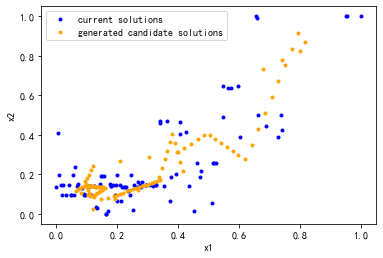

In [126]:
# 网络使用
# T = torch.as_tensor(np.random.rand(500).reshape(-1, 1), dtype=torch.float32).to(device)
# # T = torch.linspace(0, 1, 100, dtype=torch.float32).reshape(-1, 1).to(device)  # 创建隐变量
# predicts_data = []
# for i in range(len(model_list)):
#     model = model_list[i]
#     predicts = model(T)
#     predicts_data.append(predicts)
# predicts_data = torch.hstack(predicts_data).cpu().detach().numpy()

data = NDSet.Phen.copy()
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

# 绘图
data1 = data[:, [0,1]]
predicts_data1 = total_predicts_data[:, [0,1]]
# print(data1)
fig = plt.figure()
if data1.shape[1] == 2:
    plt.plot(data1[:, 0], data1[:, 1], 'o', markersize=3, color='blue', label='current solutions', )  # 绘制真实数据的图
    plt.plot(predicts_data1[:, 0], predicts_data1[:, 1], 'o', markersize=3, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
    plt.xlabel('x1')
    plt.ylabel('x2')
elif data1.shape[1] == 3:
    ax = fig.gca(projection='3d')
    ax.plot(data1[:, 0], data1[:, 1], data1[:, 2], 'o', markersize=3, color='blue', label='current solutions', )  # 绘制真实数据的图
    ax.plot(predicts_data1[:, 0], predicts_data1[:, 1], predicts_data1[:, 2], 'o', markersize=3, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
plt.legend()
plt.show()

# ↓临时工作区

2


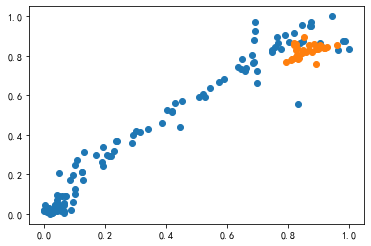

In [62]:
## 数据排序
def sort_data(data):
    N = data.shape[0]
    # 计算距离
    distance_matrix = distance.cdist(data, data, 'euclidean')
    distance_matrix[np.where(distance_matrix < 1e-12)] = np.inf
    # print(distance_matrix)
    # 找出距离最近的两个点
    min_index = np.argmin(distance_matrix)
    min_index = [min_index//N, min_index%N]
    # 开始排序
    remain = list(range(N))
    order = [min_index[0], min_index[1]]
    remain.remove(order[0])
    remain.remove(order[-1])
    while(len(remain) != 0):
        # print(distance_matrix)
        # 找到与当前order0头或尾最近的点
        min_index_A = np.argmin(distance_matrix[order[0], remain])
        min_index_B = np.argmin(distance_matrix[order[-1], remain])
        if distance_matrix[order[0], remain[min_index_A]] <= distance_matrix[order[-1], remain[min_index_B]]:
            order = [remain[min_index_A]] + order
            remain.remove(remain[min_index_A])
        else:
            order = order + [remain[min_index_B]]
            remain.remove(remain[min_index_B])
    # print(order)
    return data[order, :]

def data_cluster(data):
    """
    数据聚类。
    方法：先用DBScan，如果发现聚类数目过多，则采用k-means
    """

    distance_matrix = distance.cdist(data, data, 'euclidean')

    y_pred = DBSCAN(eps = np.mean(distance_matrix)).fit_predict(data)
    cluster_num = len(np.unique(y_pred))
    if cluster_num > data.shape[0] // 4:
        y_pred = KMeans(n_clusters=2).fit_predict(data)
    
    # y_pred = KMeans(n_clusters=2).fit_predict(data)

    unique_cluster_num = np.unique(y_pred)

    data_set = []
    for i in range(len(unique_cluster_num)):
        data_set.append(data[np.where(y_pred == unique_cluster_num[i])[0], :])
    
    return data_set

# data = np.random.rand(5, 2)
# data = createData1()
data = NDSet.Phen

data = np.unique(data, axis=0)
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

# 数据聚类，得到的data_set是一个list，每个元素都是N_k行D列的data数据。k为该类的样本数
data_set = data_cluster(data)
print(len(data_set))

# 绘图
fig = plt.figure()
for i in range(len(data_set)):
    plt.scatter((data_set[i])[:, 1], (data_set[i])[:, 2])
plt.show()

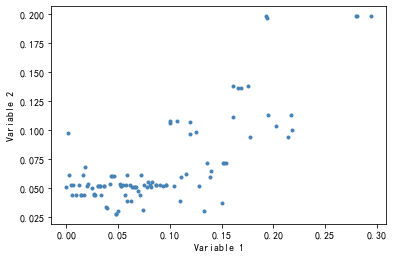

<AxesSubplot:xlabel='Variable 1', ylabel='Variable 2'>

In [127]:
ea.varplot(NDSet.Phen[:, 0:2])

# ↑临时工作区